In [2]:
# All-in-One Script for Data Loading and Integration in Google Colab (Recursive File Search)

import os
import glob
import pandas as pd
from google.colab import files

# ======================================
# Step 1: Upload the ZIP file containing your data folder
# ======================================
print("Please upload the ZIP file containing your JSON/CSV files.")
uploaded = files.upload()  # This will open a file dialog for upload

# Assuming only one file is uploaded, get its name
zip_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_filename}")

# ======================================
# Step 2: Extract the ZIP file to a directory
# ======================================
target_dir = '/content/data'
os.makedirs(target_dir, exist_ok=True)

# Unzip the uploaded file into the target directory
!unzip -o {zip_filename} -d {target_dir}

# Verify extraction by listing the files (including subdirectories)
for root, dirs, files_in_dir in os.walk(target_dir):
    print("Directory:", root)
    print("Contains files:", files_in_dir)

# ======================================
# Step 3: Recursively Scan the data folder for CSV and JSON files
# ======================================
csv_files = glob.glob(os.path.join(target_dir, '**', '*.csv'), recursive=True)
json_files = glob.glob(os.path.join(target_dir, '**', '*.json'), recursive=True)

print("CSV files found:", csv_files)
print("JSON files found:", json_files)

# ======================================
# Step 4: Load files into Pandas DataFrames with error handling
# ======================================
dataframes = []

# Load CSV files with encoding error handling
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(file, encoding='latin1')
    print(f"Loaded {file} with shape {df.shape}")
    dataframes.append(df)

# Load JSON files
for file in json_files:
    try:
        df = pd.read_json(file)
        print(f"Loaded {file} with shape {df.shape}")
    except Exception as e:
        print(f"Error reading JSON file {file}: {e}")
        continue
    dataframes.append(df)

# ======================================
# Step 5: Standardize Column Names
# ======================================
def standardize_columns(df):
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
    return df

dataframes = [standardize_columns(df) for df in dataframes]

# ======================================
# Step 6: Concatenate All DataFrames
# ======================================
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print("Combined DataFrame shape:", combined_df.shape)
else:
    combined_df = pd.DataFrame()
    print("No data loaded.")

# ======================================
# Step 7: Log Basic Information and Anomalies
# ======================================
num_records, num_features = combined_df.shape
print("Total number of records:", num_records)
print("Total number of features:", num_features)

# Check for missing values in each column
missing_values = combined_df.isnull().sum()
print("Missing values per column:\n", missing_values)


Please upload the ZIP file containing your JSON/CSV files.


Saving raw.zip to raw (1).zip
Uploaded file: raw (1).zip
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `unzip -o raw (1).zip -d /content/data'
Directory: /content/data
Contains files: []
Directory: /content/data/raw
Contains files: []
Directory: /content/data/raw/weather_raw_data
Contains files: ['weather_data_2024-01-22_to_2024-01-22.csv', 'weather_data_2023-12-03_to_2024-01-03.csv', 'weather_data_2024-01-10_to_2024-01-10.csv', 'weather_data_2024-01-24_to_2024-01-24.csv', 'weather_data_2023-12-03_to_2024-01-30.csv', 'weather_data_2023-11-03_to_2024-01-30.csv', 'weather_data_2023-12-06_to_2024-01-03.csv', 'weather_data_2022-01-01_to_2025-01-01.csv', 'weather_data_2023-12-03_to_2024-02-02.csv', 'weather_data_2024-01-07_to_2024-01-07.csv', 'weather_data_2023-01-01_to_2025-01-01.csv', 'weather_data_2024-01-26_to_2024-01-26.csv', 'weather_data_2024-01-05_to_2024-01-05.csv', 'weather_data_2024-01-19_to_2024-01-19.csv', 'weather_data_2024-01-01_to_2025-

In [3]:
# Calculate missing counts and percentages per column
missing_counts = combined_df.isnull().sum()
missing_percentages = (combined_df.isnull().sum() / combined_df.shape[0]) * 100

print("Missing Counts per Column:")
print(missing_counts)
print("\nMissing Percentages per Column:")
print(missing_percentages)


Missing Counts per Column:
date                   7679
temperature_2m         7835
response             129778
request              133069
apiversion           127584
exceladdinversion    127584
dtype: int64

Missing Percentages per Column:
date                  5.677088
temperature_2m        5.792419
response             95.944937
request              98.377975
apiversion           94.322912
exceladdinversion    94.322912
dtype: float64


In [4]:
# --- Strategy for columns with low missingness ---
# For temperature_2m, you could impute using the median (or mean)
combined_df['temperature_2m'] = combined_df['temperature_2m'].fillna(combined_df['temperature_2m'].median())

# For the date column, if imputation isn't viable, consider dropping rows missing the date
combined_df = combined_df.dropna(subset=['date'])

# --- Strategy for columns with high missingness ---
# List of columns to drop due to high missing percentages
cols_to_drop = ['response', 'request', 'apiversion', 'exceladdinversion']
combined_df = combined_df.drop(columns=cols_to_drop)

# Verify cleaning results
print("After cleaning:")
print("Total number of records:", combined_df.shape[0])
print("Total number of features:", combined_df.shape[1])
print("Missing values per column:\n", combined_df.isnull().sum())


After cleaning:
Total number of records: 127584
Total number of features: 2
Missing values per column:
 date              0
temperature_2m    0
dtype: int64


In [5]:
import pandas as pd

# Assuming combined_df is your cleaned DataFrame with 'date' and 'temperature_2m'

# 1. Convert 'date' column to datetime
combined_df['date'] = pd.to_datetime(combined_df['date'], errors='coerce')

# Verify the conversion
print("Date column after conversion:")
print(combined_df['date'].head())

# 2. Extract additional temporal features
# Extract hour, day, month, and year from the datetime column
combined_df['hour'] = combined_df['date'].dt.hour
combined_df['day'] = combined_df['date'].dt.day
combined_df['month'] = combined_df['date'].dt.month
combined_df['year'] = combined_df['date'].dt.year

# Define a function to determine the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# Create a new 'season' column using the extracted month
combined_df['season'] = combined_df['month'].apply(get_season)

# Convert 'season' to a categorical data type with an order
combined_df['season'] = pd.Categorical(combined_df['season'],
                                       categories=['Winter', 'Spring', 'Summer', 'Autumn'],
                                       ordered=True)

# 3. Ensure numerical columns are correctly cast
# Convert 'temperature_2m' to a numeric type (float)
combined_df['temperature_2m'] = pd.to_numeric(combined_df['temperature_2m'], errors='coerce')

# Display a few rows to verify the data types and new features
print("\nDataFrame after type conversions and feature extraction:")
print(combined_df.head())

# Optional: Check the data types of the DataFrame
print("\nData types in the DataFrame:")
print(combined_df.dtypes)


Date column after conversion:
0   2024-01-22 05:00:00
1   2024-01-22 06:00:00
2   2024-01-22 07:00:00
3   2024-01-22 08:00:00
4   2024-01-22 09:00:00
Name: date, dtype: datetime64[ns]

DataFrame after type conversions and feature extraction:
                 date  temperature_2m  hour   day  month    year  season
0 2024-01-22 05:00:00          5.1585   5.0  22.0    1.0  2024.0  Winter
1 2024-01-22 06:00:00          5.5585   6.0  22.0    1.0  2024.0  Winter
2 2024-01-22 07:00:00          5.7585   7.0  22.0    1.0  2024.0  Winter
3 2024-01-22 08:00:00          6.1085   8.0  22.0    1.0  2024.0  Winter
4 2024-01-22 09:00:00          5.8585   9.0  22.0    1.0  2024.0  Winter

Data types in the DataFrame:
date              datetime64[ns]
temperature_2m           float64
hour                     float64
day                      float64
month                    float64
year                     float64
season                  category
dtype: object


In [6]:
import pandas as pd

# Assume combined_df is your cleaned DataFrame from previous steps.

# ----------------------------------------
# 1. Detect and Remove Duplicate Rows
# ----------------------------------------
# Count duplicate rows
duplicate_count = combined_df.duplicated().sum()
print("Number of duplicate rows before removal:", duplicate_count)

# Remove duplicate rows
combined_df = combined_df.drop_duplicates()
print("Shape after removing duplicates:", combined_df.shape)

# ----------------------------------------
# 2. Identify Outliers in 'temperature_2m'
# ----------------------------------------
# Calculate the first (Q1) and third (Q3) quartiles
Q1 = combined_df['temperature_2m'].quantile(0.25)
Q3 = combined_df['temperature_2m'].quantile(0.75)
IQR = Q3 - Q1

print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound, "Upper Bound:", upper_bound)

# Identify outlier rows
outliers = combined_df[(combined_df['temperature_2m'] < lower_bound) | (combined_df['temperature_2m'] > upper_bound)]
print("Number of outlier rows in 'temperature_2m':", outliers.shape[0])

# ----------------------------------------
# 3. Remove Outliers from the DataFrame
# ----------------------------------------
# Filter out outliers
combined_df_no_outliers = combined_df[(combined_df['temperature_2m'] >= lower_bound) & (combined_df['temperature_2m'] <= upper_bound)]
print("Shape after removing outliers:", combined_df_no_outliers.shape)


Number of duplicate rows before removal: 123781
Shape after removing duplicates: (3803, 7)
Q1: 2.6585 Q3: 11.7085 IQR: 9.05
Lower Bound: -10.916500000000001 Upper Bound: 25.283500000000004
Number of outlier rows in 'temperature_2m': 192
Shape after removing outliers: (3611, 7)


In [7]:
# ----------------------------
# Feature Engineering
# ----------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assume 'combined_df_no_outliers' is your cleaned DataFrame with at least the following columns:
# 'date' (datetime) and 'temperature_2m' (numeric)

# Make a copy of the DataFrame to work with
df = combined_df_no_outliers.copy()

# --- Derive Temporal Features from the 'date' Column ---

# 1. Day of the week: 0=Monday, 6=Sunday and its name
df['day_of_week'] = df['date'].dt.dayofweek
df['day_name'] = df['date'].dt.day_name()

# 2. Is_weekend flag: 1 if the day is Saturday (5) or Sunday (6), otherwise 0
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Holiday flag (if applicable)
# Install the 'holidays' package if not already installed. Uncomment the next line if needed.
# !pip install holidays

import holidays
# Define a holiday calendar; here we assume US holidays.
us_holidays = holidays.US()

# Create a flag for whether a date is a US holiday (1 for holiday, 0 otherwise)
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)

# --- Normalize / Standardize Numerical Features ---

# For demonstration, we standardize 'temperature_2m' using StandardScaler.
scaler = StandardScaler()
df['temperature_2m_scaled'] = scaler.fit_transform(df[['temperature_2m']])

# Display the first few rows to verify new features and normalization
print("Engineered Features:")
print(df.head())

# Check DataFrame data types to ensure proper conversions
print("\nData Types in the Engineered DataFrame:")
print(df.dtypes)


Engineered Features:
                 date  temperature_2m  hour   day  month    year  season  \
0 2024-01-22 05:00:00          5.1585   5.0  22.0    1.0  2024.0  Winter   
1 2024-01-22 06:00:00          5.5585   6.0  22.0    1.0  2024.0  Winter   
2 2024-01-22 07:00:00          5.7585   7.0  22.0    1.0  2024.0  Winter   
3 2024-01-22 08:00:00          6.1085   8.0  22.0    1.0  2024.0  Winter   
4 2024-01-22 09:00:00          5.8585   9.0  22.0    1.0  2024.0  Winter   

   day_of_week day_name  is_weekend  is_holiday  temperature_2m_scaled  
0          0.0   Monday           0           0              -0.259284  
1          0.0   Monday           0           0              -0.200861  
2          0.0   Monday           0           0              -0.171650  
3          0.0   Monday           0           0              -0.120529  
4          0.0   Monday           0           0              -0.157044  

Data Types in the Engineered DataFrame:
date                     datetime64[ns]
tem

=== Statistical Summary ===
       temperature_2m         hour          day        month    year  \
count     3611.000000  2923.000000  2923.000000  2923.000000  2923.0   
mean         6.933715    11.496408    15.508040     2.520698  2024.0   
std          6.847542     6.928616     8.802778     1.142109     0.0   
min        -10.491500     0.000000     1.000000     1.000000  2024.0   
25%          2.408500     5.000000     8.000000     1.000000  2024.0   
50%          6.958500    11.000000    15.000000     3.000000  2024.0   
75%         10.608500    18.000000    23.000000     4.000000  2024.0   
max         25.258501    23.000000    31.000000     5.000000  2024.0   

       day_of_week  temperature_2m_scaled  
count  2923.000000           3.611000e+03  
mean      2.959631           9.445043e-17  
std       1.999764           1.000138e+00  
min       0.000000          -2.545093e+00  
25%       1.000000          -6.609440e-01  
50%       3.000000           3.620091e-03  
75%       5.000

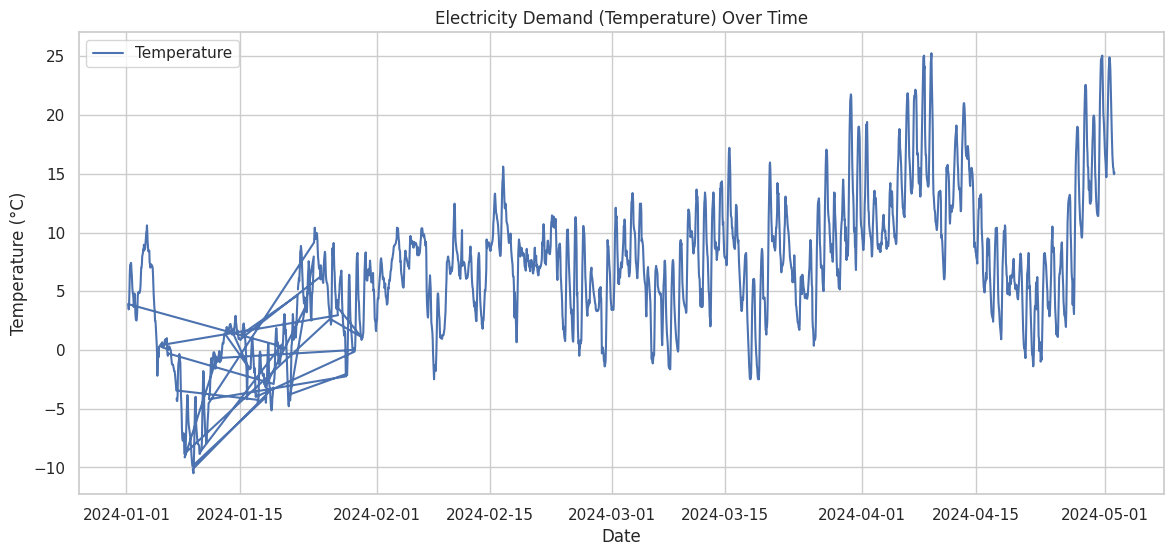

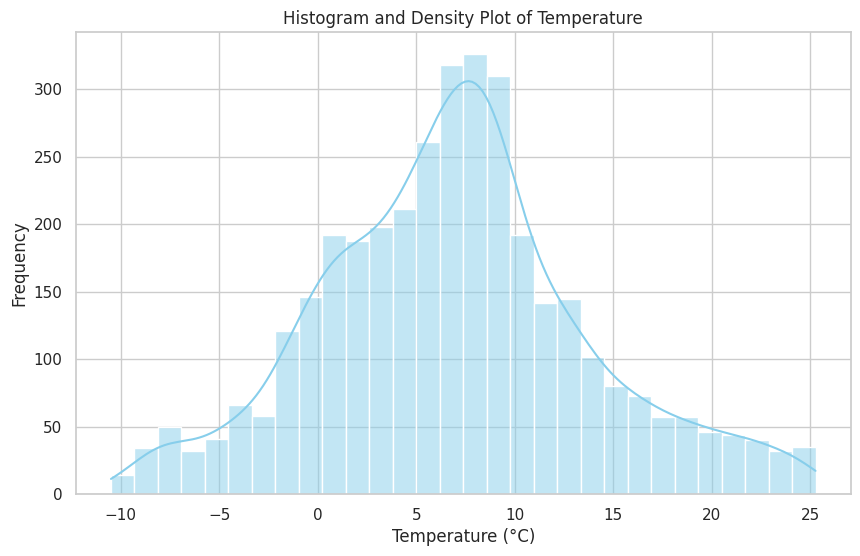

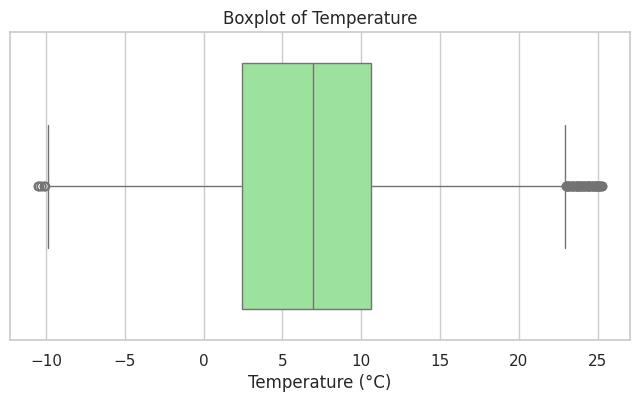

<ipython-input-11-fc343f987523>:70: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['temperature_2m'], shade=True, color='r')


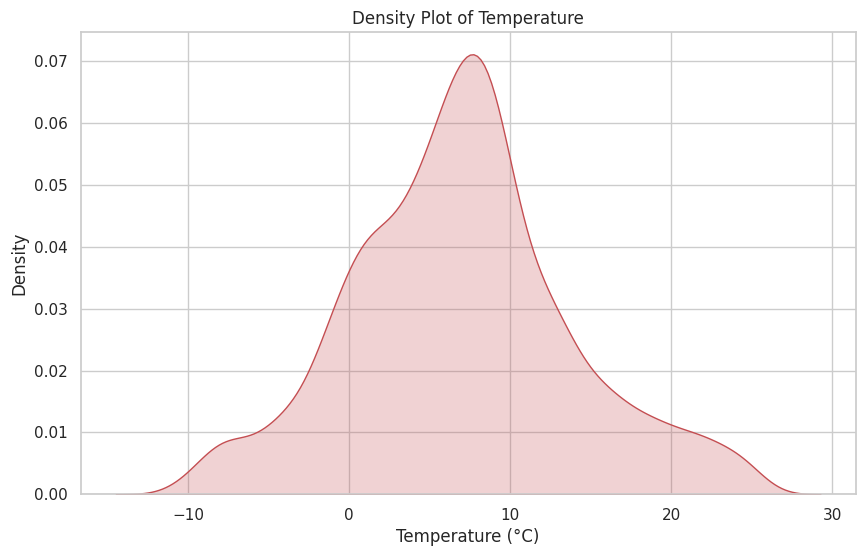


=== Correlation Matrix ===
                       temperature_2m      hour       day     month  year  \
temperature_2m               1.000000  0.120903 -0.020858  0.602388   NaN   
hour                         0.120903  1.000000 -0.000753 -0.008889   NaN   
day                         -0.020858 -0.000753  1.000000 -0.047324   NaN   
month                        0.602388 -0.008889 -0.047324  1.000000   NaN   
year                              NaN       NaN       NaN       NaN   NaN   
day_of_week                  0.046259 -0.002950  0.025253  0.006659   NaN   
temperature_2m_scaled        1.000000  0.120903 -0.020858  0.602388   NaN   

                       day_of_week  temperature_2m_scaled  
temperature_2m            0.046259               1.000000  
hour                     -0.002950               0.120903  
day                       0.025253              -0.020858  
month                     0.006659               0.602388  
year                           NaN                    N

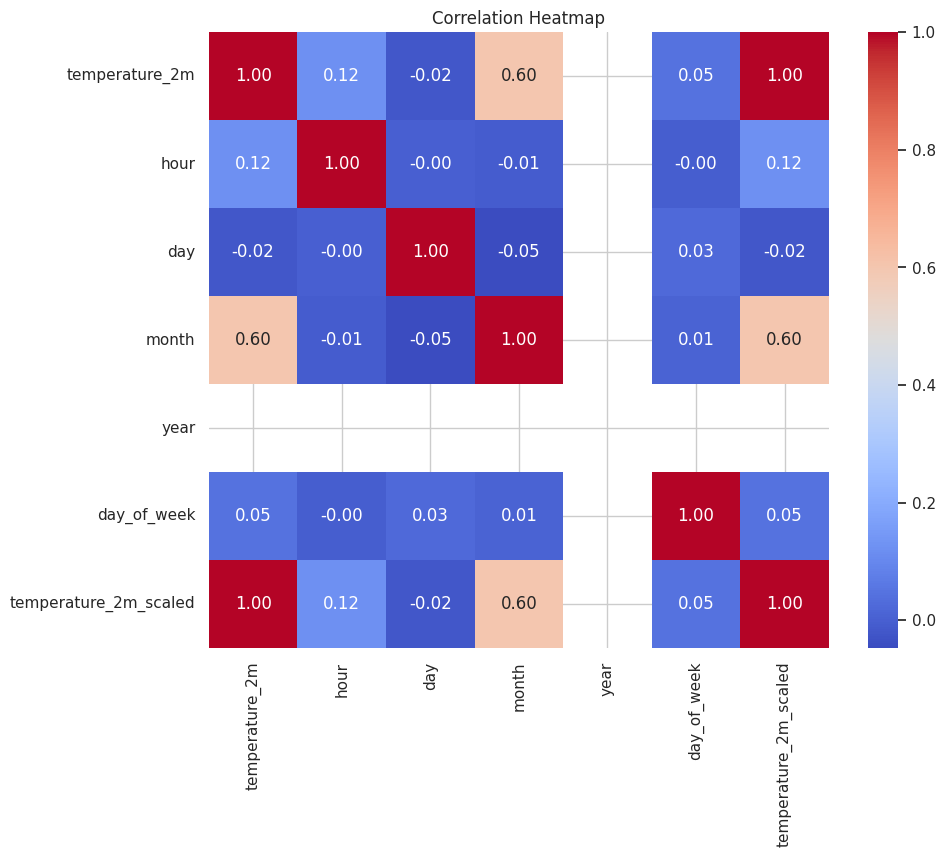


=== Augmented Dickey-Fuller Test ===
ADF Statistic: -5.039413
p-value: 0.000019
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567


In [11]:
# ------------------------------
# Exploratory Data Analysis (EDA)
# ------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Set plot style and figure size for consistency
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ------------------------------------------------------------------
# ASSUMPTION:
# 'df' is the engineered DataFrame that includes the following columns:
# - 'date' (datetime), 'temperature_2m' (numeric), 'hour', 'day', 'month', 'year',
#   'season', 'day_of_week', 'day_name', 'is_weekend', 'is_holiday', and 'temperature_2m_scaled'
# ------------------------------------------------------------------

# -----------------------------------
# 1. Statistical Summary for Numerical Features
# -----------------------------------
# Define numerical columns for summary analysis. Adjust as needed.
num_cols = ['temperature_2m', 'hour', 'day', 'month', 'year', 'day_of_week', 'temperature_2m_scaled']

print("=== Statistical Summary ===")
print(df[num_cols].describe())

print("\nSkewness of numerical features:")
print(df[num_cols].skew())

print("\nKurtosis of numerical features:")
print(df[num_cols].kurt())

# -----------------------------------
# 2. Time Series Analysis
# -----------------------------------
# Plot the electricity demand (using 'temperature_2m' as a proxy) over time
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['temperature_2m'], color='b', label='Temperature')
plt.title("Electricity Demand (Temperature) Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------
# 3. Univariate Analysis
# -----------------------------------
# Histogram with density plot for 'temperature_2m'
plt.figure(figsize=(10, 6))
sns.histplot(df['temperature_2m'], kde=True, bins=30, color='skyblue')
plt.title("Histogram and Density Plot of Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Boxplot for 'temperature_2m'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['temperature_2m'], color='lightgreen')
plt.title("Boxplot of Temperature")
plt.xlabel("Temperature (°C)")
plt.show()

# Optional: Separate density plot for 'temperature_2m'
plt.figure(figsize=(10, 6))
sns.kdeplot(df['temperature_2m'], shade=True, color='r')
plt.title("Density Plot of Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.show()

# -----------------------------------
# 4. Correlation Analysis
# -----------------------------------
# Compute the correlation matrix for numerical features
corr_matrix = df[num_cols].corr()
print("\n=== Correlation Matrix ===")
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# -----------------------------------
# 5. Advanced Time Series Techniques (Stationarity Test Only)
# -----------------------------------
# For stationarity tests, set 'date' as the index
df_ts = df.set_index('date').sort_index()

# Before applying the ADF test, drop any NaN or Inf values from 'temperature_2m'
temp_series = df_ts['temperature_2m'].replace([np.inf, -np.inf], np.nan).dropna()

# Augmented Dickey-Fuller (ADF) Test to assess stationarity
adf_result = adfuller(temp_series)
print("\n=== Augmented Dickey-Fuller Test ===")
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.3f}")

# Interpretation:
# A low p-value (typically < 0.05) indicates that the time series is stationary.


Number of outliers detected by IQR method: 73


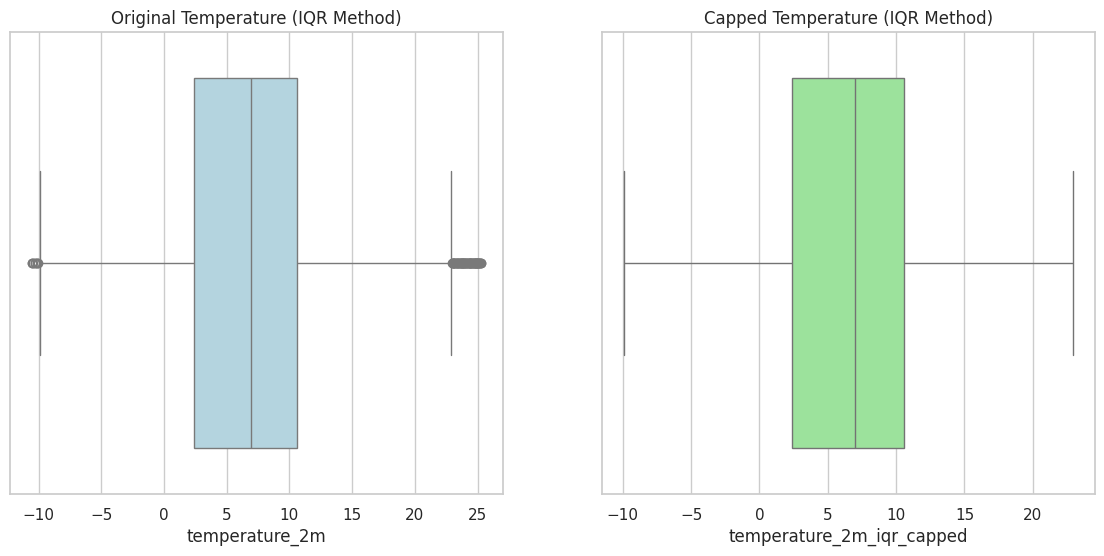

Number of outliers detected by Z-score method: 0


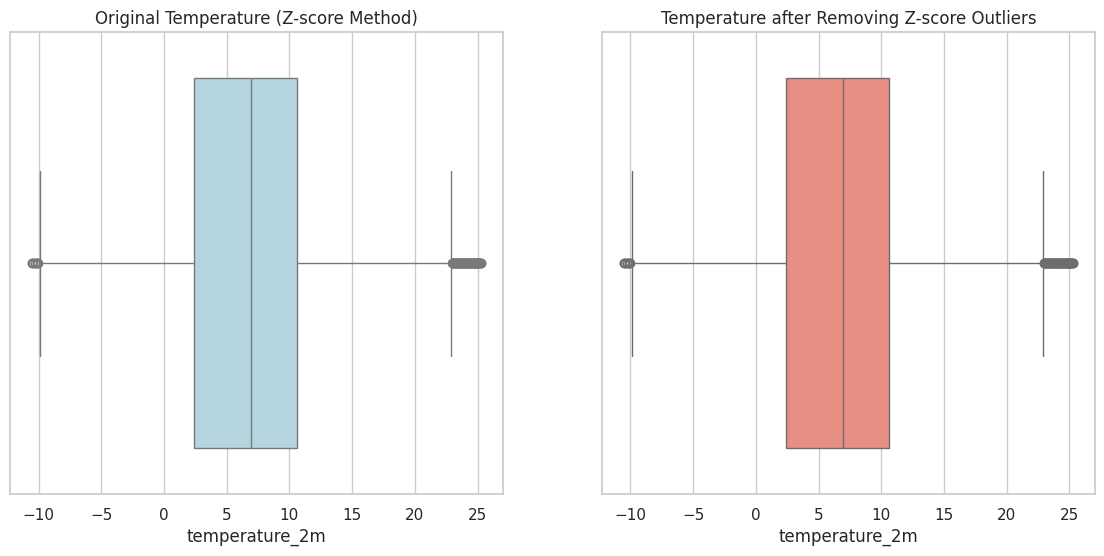

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set a consistent style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -----------------------------------
# ASSUMPTION:
# 'df' is your DataFrame and it includes a numerical column 'temperature_2m'.
# -----------------------------------

# ============================================================
# 1. Outlier Detection and Handling using IQR-based Method
# ============================================================

# Calculate Q1, Q3, and the IQR for the temperature data
Q1 = df['temperature_2m'].quantile(0.25)
Q3 = df['temperature_2m'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers: points outside [lower_bound, upper_bound]
df['iqr_outlier'] = ((df['temperature_2m'] < lower_bound) | (df['temperature_2m'] > upper_bound)).astype(int)
num_outliers_iqr = df['iqr_outlier'].sum()
print("Number of outliers detected by IQR method:", num_outliers_iqr)

# Handling Strategy: Cap (Winsorize) outliers
# Rationale: Capping outliers preserves the overall dataset size while limiting the influence of extreme values.
df['temperature_2m_iqr_capped'] = df['temperature_2m'].copy()
df.loc[df['temperature_2m_iqr_capped'] < lower_bound, 'temperature_2m_iqr_capped'] = lower_bound
df.loc[df['temperature_2m_iqr_capped'] > upper_bound, 'temperature_2m_iqr_capped'] = upper_bound

# Before-and-after visualization for IQR-based capping
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['temperature_2m'], color='lightblue')
plt.title("Original Temperature (IQR Method)")
plt.subplot(1, 2, 2)
sns.boxplot(x=df['temperature_2m_iqr_capped'], color='lightgreen')
plt.title("Capped Temperature (IQR Method)")
plt.show()

# ============================================================
# 2. Outlier Detection and Handling using Z-score Method
# ============================================================

# Compute Z-scores for temperature_2m
df['temp_z'] = stats.zscore(df['temperature_2m'])

# Flag outliers: any point with |Z| > 3
df['z_outlier'] = (df['temp_z'].abs() > 3).astype(int)
num_outliers_z = df['z_outlier'].sum()
print("Number of outliers detected by Z-score method:", num_outliers_z)

# Handling Strategy: Remove extreme outliers detected by the Z-score method
# Rationale: When the number of extreme outliers is small, removal minimizes distortion in statistical analyses.
df_z = df[df['z_outlier'] == 0].copy()

# Before-and-after visualization for Z-score method (removal)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['temperature_2m'], color='lightblue')
plt.title("Original Temperature (Z-score Method)")
plt.subplot(1, 2, 2)
sns.boxplot(x=df_z['temperature_2m'], color='salmon')
plt.title("Temperature after Removing Z-score Outliers")
plt.show()

# Document modifications:
# - IQR-based method: Outliers were capped to the calculated lower and upper bounds.
# - Z-score method: Outliers with |Z| > 3 were removed.


Model Evaluation Metrics:
Mean Squared Error (MSE): 34.07221971054654
Root Mean Squared Error (RMSE): 5.8371413988823795
R² Score: 0.21238607001071197


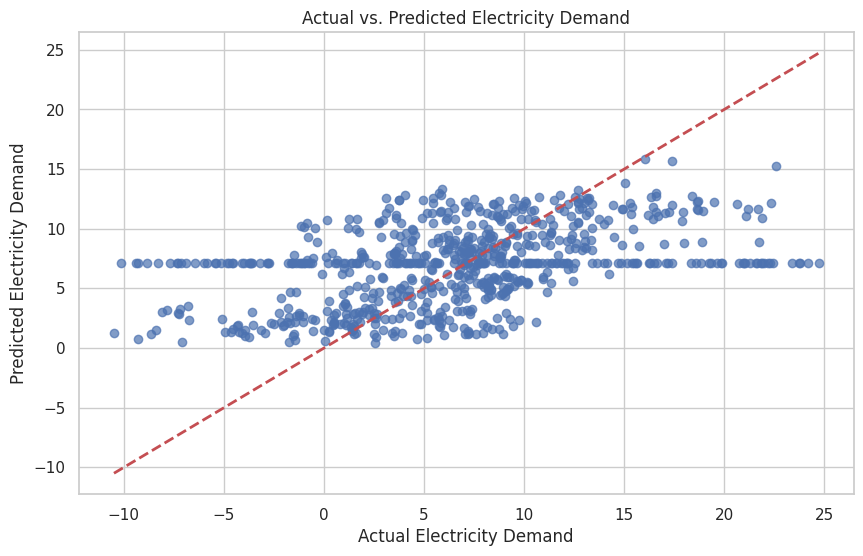

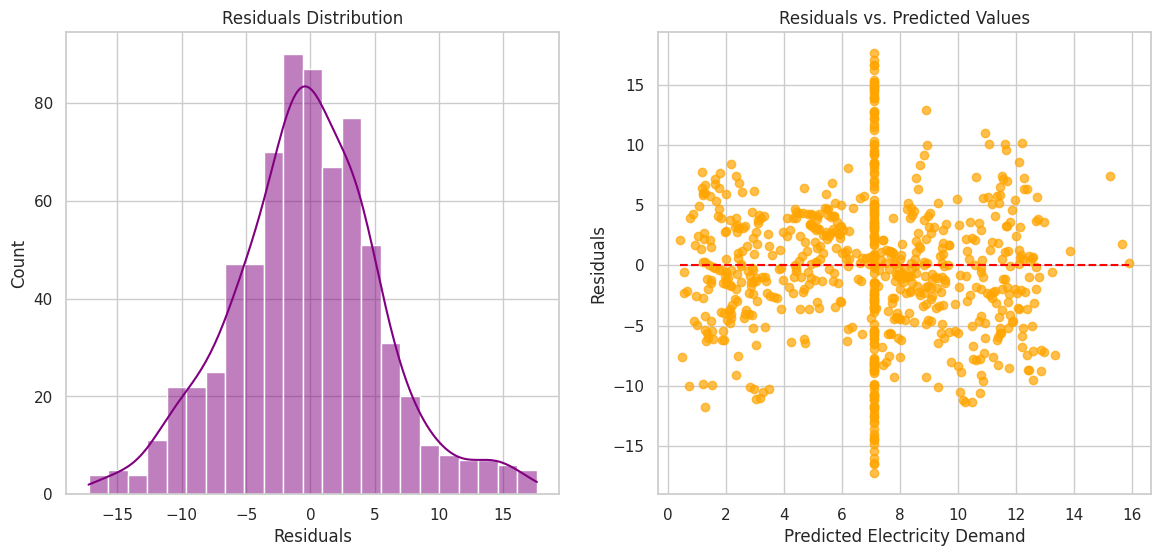

In [14]:
# 5. Regression Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# For reproducibility
np.random.seed(42)

# ------------------------------------------------------------------
# ASSUMPTION:
# The processed DataFrame 'df' includes:
# - Time features: 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'is_holiday'
# - The target variable: electricity demand.
# In this example, we assume that the column "electricity_demand" is the same as "temperature_2m".
# ------------------------------------------------------------------

# For demonstration, create a target column 'electricity_demand'
df['electricity_demand'] = df['temperature_2m']

# ------------------------------
# Feature Selection
# ------------------------------
# Select time-based features as predictors
features = ['hour', 'day', 'month', 'day_of_week', 'is_weekend', 'is_holiday']
X = df[features]
y = df['electricity_demand']

# ------------------------------
# Data Splitting
# ------------------------------
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# Handling Missing Values in Features
# ------------------------------
# Use mean imputation to fill missing values in X_train and X_test
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# ------------------------------
# Model Development
# ------------------------------
# Build a linear regression model
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_imputed)

# ------------------------------
# Model Evaluation
# ------------------------------
# Compute evaluation metrics: MSE, RMSE, and R² score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs. Predicted Electricity Demand")
plt.xlabel("Actual Electricity Demand")
plt.ylabel("Predicted Electricity Demand")
plt.show()

# ------------------------------
# Residual Analysis
# ------------------------------
residuals = y_test - y_pred

plt.figure(figsize=(14, 6))

# Histogram & Density Plot of Residuals
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")

# Residuals vs. Predicted Values Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.7, color='orange')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Electricity Demand")
plt.ylabel("Residuals")
plt.show()
